# Clasificador de Perros y Gatos

Este notebook implementa un modelo CNN para clasificar imágenes de perros y gatos.


In [ ]:
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import cv2
from pathlib import Path
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import kagglehub

c:\projects\python\clasificator-cat-dogs\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Descargar y explorar el dataset


In [ ]:
path = kagglehub.dataset_download(
    "bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

data = Path(path)
print("Datos disponibles:", data)

Path to dataset files: C:\Users\inder\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1
Datos disponibles: C:\Users\inder\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1


In [ ]:
image_files = list(data.glob('**/*.jpg'))
print(f"Total de imágenes: {len(image_files)}")

Total de imágenes encontradas: 24998
Ejemplos de rutas: [WindowsPath('C:/Users/inder/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/0.jpg'), WindowsPath('C:/Users/inder/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/1.jpg'), WindowsPath('C:/Users/inder/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/10.jpg'), WindowsPath('C:/Users/inder/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/100.jpg'), WindowsPath('C:/Users/inder/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/1000.jpg')]


Ejemplo de gato: C:\Users\inder\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1\PetImages\Cat\10087.jpg
Ejemplo de perro: C:\Users\inder\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1\PetImages\Dog\10087.jpg


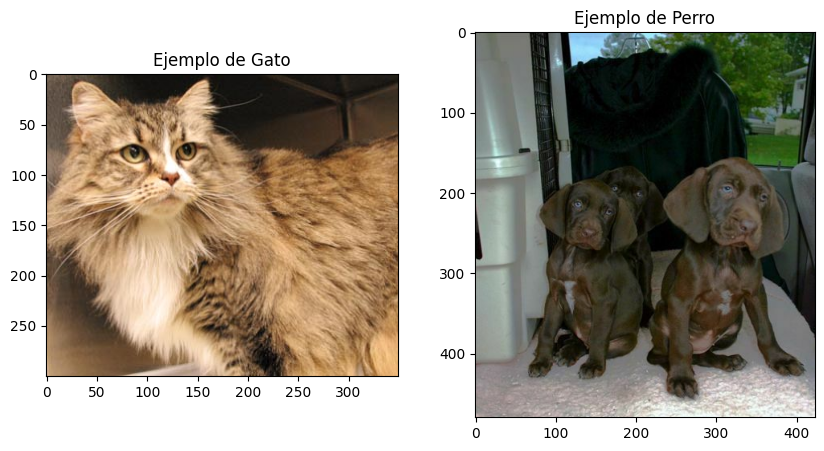

In [ ]:
try:
    cat_example = list(data.glob('PetImages/Cat/*.*'))[100]
    dog_example = list(data.glob('PetImages/Dog/*.*'))[100]
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Gato")
    plt.imshow(np.array(Image.open(str(cat_example))))
    
    plt.subplot(1, 2, 2)
    plt.title("Perro")
    plt.imshow(np.array(Image.open(str(dog_example))))
    plt.show()
except Exception as e:
    print(f"Error al mostrar imágenes de ejemplo: {e}")

## Preparación de los datos


In [ ]:
animals = {
    'dog': list(data.glob('PetImages/Dog/*.*')),
    'cat': list(data.glob('PetImages/Cat/*.*')),
}

label = {
    'dog': 1,
    'cat': 0,
}

print(f"Imágenes de perro: {len(animals['dog'])}")
print(f"Imágenes de gato: {len(animals['cat'])}")

Imágenes de perro: 12499
Imágenes de gato: 12499


In [ ]:
def load_and_preprocess_image(image_path, target_size=(150, 150)):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_resized = cv2.resize(img, target_size)

        img_normalized = img_resized / 255.0

        return (img_normalized.astype(np.float32))
    except Exception as e:
        print(f"Error procesando {image_path}: {e}")
        return None

In [ ]:
X = []
Y = []
total_images = sum(len(images) for images in animals.values())

for name, images in animals.items():
    for image in images:

        image_path = str(image).strip()
        img_processed = load_and_preprocess_image(image_path)

        if img_processed is not None:
            X.append(img_processed)
            Y.append(label[name])
            print(len(X))

Procesando 24998 imágenes...
Procesadas 1000/24998 imágenes
Procesadas 2000/24998 imágenes
Procesadas 3000/24998 imágenes
Procesadas 4000/24998 imágenes
Procesadas 5000/24998 imágenes
Procesadas 6000/24998 imágenes
Procesadas 7000/24998 imágenes
Procesadas 8000/24998 imágenes
Procesadas 9000/24998 imágenes
Procesadas 10000/24998 imágenes
Procesadas 11000/24998 imágenes
Procesadas 12000/24998 imágenes
Procesadas 13000/24998 imágenes
Procesadas 14000/24998 imágenes
Procesadas 15000/24998 imágenes
Procesadas 16000/24998 imágenes
Procesadas 17000/24998 imágenes
Procesadas 18000/24998 imágenes
Procesadas 19000/24998 imágenes
Procesadas 20000/24998 imágenes
Procesadas 21000/24998 imágenes
Procesadas 22000/24998 imágenes
Procesadas 23000/24998 imágenes
Procesadas 24000/24998 imágenes
Imágenes cargadas correctamente: 24946 de 24998


In [ ]:
X = np.array(X)
Y = np.array(Y)

print(f"Forma del conjunto: {X.shape}")
print(f"Distribución de clases: {np.bincount(Y)}")

Forma del conjunto de datos: (24946, 150, 150, 3)
Distribución de clases: [12476 12470]


## División de los datos y creación del modelo


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42,
    stratify=Y)

print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}, {y_test.shape}")

Conjunto de entrenamiento: (19956, 150, 150, 3), (19956,)
Conjunto de prueba: (4990, 150, 150, 3), (4990,)


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [ ]:
def build_model(input_shape=(150, 150, 3)):
    model = Sequential([
        data_augmentation,

        layers.Conv2D(32, (3, 3), activation='relu',
                      padding='same',
                      input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = build_model(input_shape=X_train[0].shape)
model.summary()

c:\projects\python\clasificator-cat-dogs\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo


In [ ]:
callbacks = [
    EarlyStopping(patience=10,
                  restore_best_weights=True,
                  monitor='val_accuracy'),

    ReduceLROnPlateau(factor=0.2,
                      patience=5,
                      min_lr=1e-6,
                      monitor='val_loss')
]

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 133s 266ms/step - accuracy: 0.5535 - loss: 1.2165 - val_accuracy: 0.6408 - val_loss: 0.7689 - learning_rate: 1.0000e-04
Epoch 2/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 131s 263ms/step - accuracy: 0.6666 - loss: 0.7263 - val_accuracy: 0.7179 - val_loss: 0.6246 - learning_rate: 1.0000e-04
Epoch 3/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 133s 266ms/step - accuracy: 0.7084 - loss: 0.6352 - val_accuracy: 0.7497 - val_loss: 0.5736 - learning_rate: 1.0000e-04
Epoch 4/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 155s 292ms/step - accuracy: 0.7230 - loss: 0.6007 - val_accuracy: 0.7485 - val_loss: 0.5520 - learning_rate: 1.0000e-04
Epoch 5/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 148s 296ms/step - accuracy: 0.7311 - loss: 0.5769 - val_accuracy: 0.7695 - val_loss: 0.5216 - learning_rate: 1.0000e-04


## Evaluación del modelo


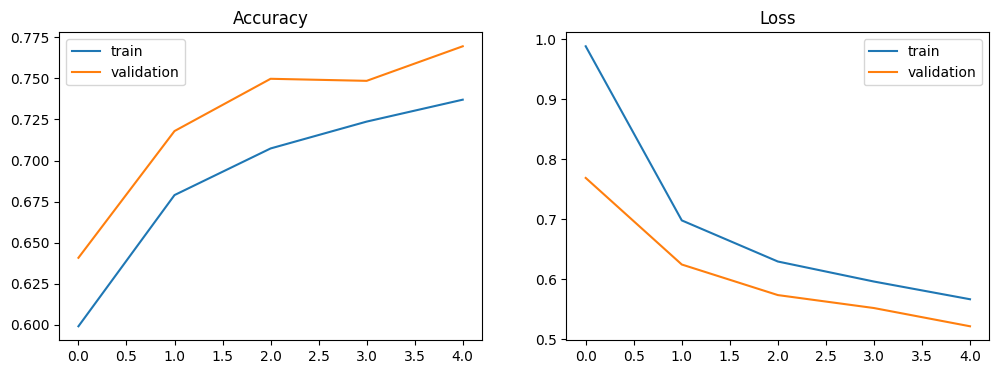

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7645 - loss: 0.5248
Precisión en el conjunto de prueba: 0.7715


In [ ]:
model.save('models/cat_dog_classifier_improved.h5')

Modelo guardado correctamente
